In [8]:
import os
import cv2
import numpy as np

dataset_path = "C://Users//ranju//OneDrive//Desktop//GaitDatasetA-silh"

img_size = (224, 224)
data = []
labels = []

for employee in os.listdir(dataset_path):
    employee_path = os.path.join(dataset_path, employee)
    if os.path.isdir(employee_path):  
        for subfolder in os.listdir(employee_path):
            subfolder_path = os.path.join(employee_path, subfolder)
            for img_name in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size) 
                    data.append(img)
                    labels.append(employee)  


data = np.array(data, dtype="float32") / 255.0  
labels = np.array(labels)


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)


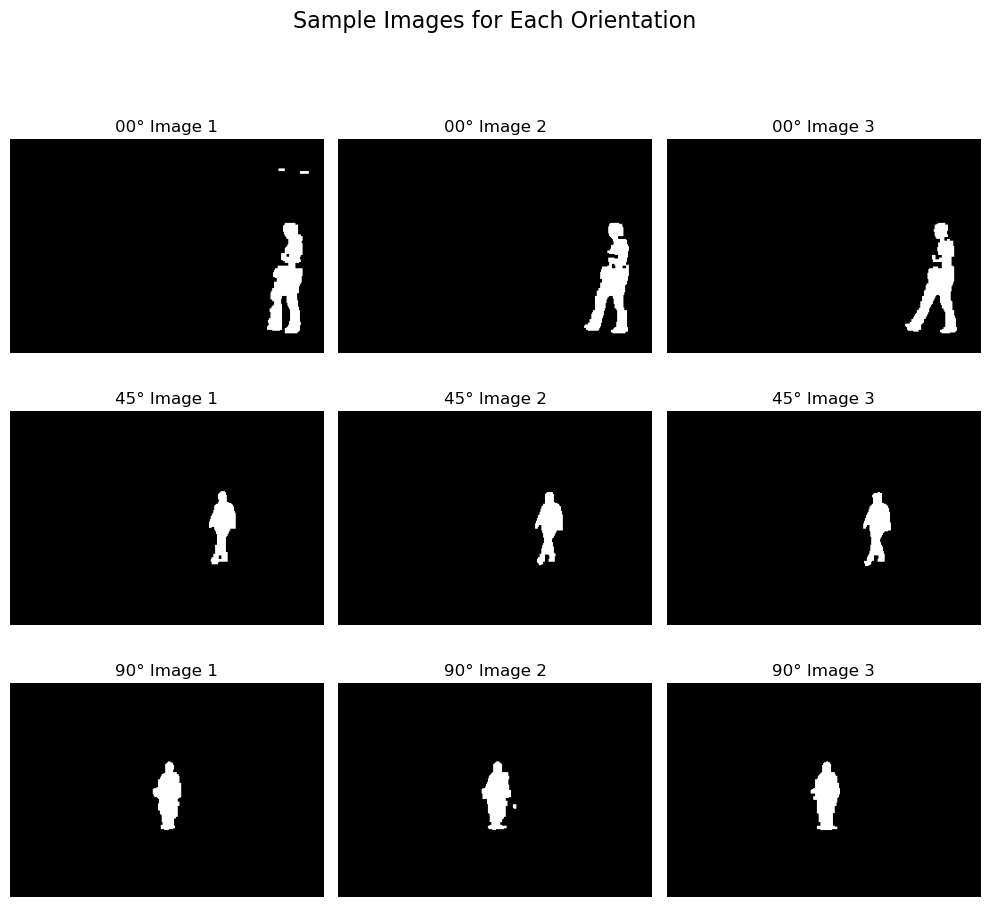

In [12]:
import matplotlib.pyplot as plt

orientations = ["00", "45", "90"]


def get_images_for_orientation(base_path, orientations, num_images=3):
    images = {orientation: [] for orientation in orientations}
    for orientation in orientations:
        for subfolder in os.listdir(base_path):
            if subfolder.startswith(orientation) and len(images[orientation]) < num_images:
                subfolder_path = os.path.join(base_path, subfolder)
                for img_name in os.listdir(subfolder_path):
                    img_path = os.path.join(subfolder_path, img_name)
                    img = cv2.imread(img_path)
                    if img is not None and len(images[orientation]) < num_images:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
                        images[orientation].append(img)
    return images

images = get_images_for_orientation(os.path.join(dataset_path, "fyc"), orientations)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Sample Images for Each Orientation", fontsize=16)

for i, orientation in enumerate(orientations):
    for j, img in enumerate(images[orientation]):
        axs[i, j].imshow(img)
        axs[i, j].set_title(f"{orientation}° Image {j+1}")
        axs[i, j].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(data, labels_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Testing size: {len(X_test)}")


Training size: 6380, Validation size: 1367, Testing size: 1368


## import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Parameters
input_shape = (224, 224, 3)  # Input image size
num_classes = len(set(labels_encoded))  # Number of unique employee labels

# Define the CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


In [50]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  
    batch_size=32
)


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 621ms/step - accuracy: 0.4758 - loss: 1.3768 - val_accuracy: 0.8727 - val_loss: 0.2984
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 120s 598ms/step - accuracy: 0.8658 - loss: 0.3256 - val_accuracy: 0.9217 - val_loss: 0.1854
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 121s 604ms/step - accuracy: 0.9268 - loss: 0.1941 - val_accuracy: 0.9400 - val_loss: 0.1516
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 120s 597ms/step - accuracy: 0.9567 - loss: 0.1244 - val_accuracy: 0.9678 - val_loss: 0.0923
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 119s 593ms/step - accuracy: 0.9733 - loss: 0.0764 - val_accuracy: 0.9663 - val_loss: 0.0899
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 121s 603ms/step - accuracy: 0.9785 - loss: 0.0596 - val_accuracy: 0.9715 - val_loss: 0.0776
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 624ms/step - accuracy: 0.9841 - loss: 0.0510 - val_accuracy: 0.9722 - val_loss: 0.0776
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 123s 613ms/step - accuracy: 0.9885 -

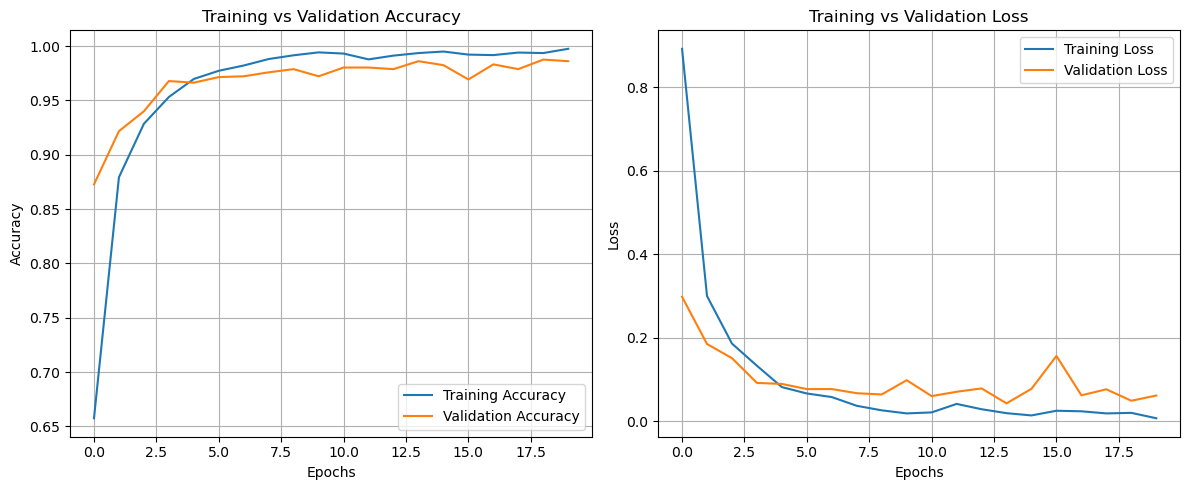

In [51]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [52]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9887 - loss: 0.0360
Test Accuracy: 98.98%


In [53]:
def predict_employee(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img / 255.0, axis=0)  
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    return le.inverse_transform([predicted_class])[0]

print("Predicted Employee:", predict_employee("C:\\Users\\ranju\\OneDrive\\Desktop\\GaitDatasetA-silh\\hy\\45_1\\hy-45_1-001.png"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Predicted Employee: hy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


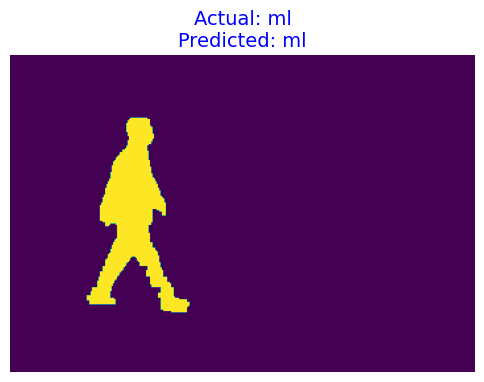

Prediction probabilities: [0.0000000e+00 7.6212870e-37 2.7051394e-34 5.4242639e-33 1.5889822e-36
 1.0000000e+00 3.2817924e-36 3.3068073e-32 1.7892001e-29]


In [58]:
import matplotlib.pyplot as plt

def predict_employee(image_path, actual_label, model, class_names):
   
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]
    
    # Display the image along with actual and predicted labels
    plt.figure(figsize=(6, 6))
    plt.imshow(plt.imread(image_path))  # Display the actual image
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_class}", fontsize=14, color='blue')
    plt.show()

    # Print the prediction probabilities for reference
    print(f"Prediction probabilities: {predictions[0]}")

# Example image path and actual label
image_path = "C:\\Users\\ranju\\OneDrive\\Desktop\\GaitDatasetA-silh\\ml\\00_2\\ml-00_2-016.png"
actual_label = "ml"

# List of class names (e.g., ['Employee1', 'Employee2', ..., 'Employee20'])
class_names = ['fyc', 'hy', 'ljg', 'lqf', 'lsl', 'ml', 'nhz', 'rj', 'syj', 'wl', 'wq', 'wyc', 
'xch', 'xxj', 'yjf', 'zc', 'zdx', 'zjg', 'zl', 'zyf']

# Call the function
predict_employee(image_path, actual_label, model, class_names)



In [61]:
import os
import tensorflow as tf

def predict_employee_from_folder(folder_path, model, class_names):
   
    predictions = []
    
    # List all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalize pixel values
        img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict the class
        pred = model.predict(img_array)
        predicted_class = class_names[tf.argmax(pred[0]).numpy()]

        # Store the result
        predictions.append((img_file, predicted_class))

        # Optionally, display the image with its prediction
        print(f"Image: {img_file}, Predicted Employee: {predicted_class}")
    
    return predictions

employee_folder = "C:\\Users\\ranju\\OneDrive\\Desktop\\GaitDatasetA-silh\\ml\\45_3"
class_names = ['fyc', 'hy', 'ljg', 'lqf', 'lsl', 'ml', 'nhz', 'rj', 'syj', 'wl', 'wq', 'wyc', 
'xch', 'xxj', 'yjf', 'zc', 'zdx', 'zjg', 'zl', 'zyf']  
predictions = predict_employee_from_folder(employee_folder, model, class_names)
print('Actual Label: ml')
print(f'Predicted Label: {max(set(predictions[1]), key=predictions.count)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Image: ml-45_3-001.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image: ml-45_3-002.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image: ml-45_3-003.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Image: ml-45_3-004.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image: ml-45_3-005.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image: ml-45_3-006.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image: ml-45_3-007.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Image: ml-45_3-008.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: ml-45_3-009.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Image: ml-45_3-010.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image: ml-45_3-011.png, Predicted Employee: ml
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: ml-45_3-012.png, P